In [226]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#<font color='orange'>Basics</font>

In [227]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [229]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [231]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

In [232]:
ls -d  ../data/riData/*/

../data/riData/area_under_the_kick//   ../data/riData/Kickout_ls//
../data/riData/Best_ex_by_ar//         ../data/riData/LC//
../data/riData/Best_ls_by_ar//         ../data/riData/LC_py//
../data/riData/Data//                  ../data/riData/Load//
../data/riData/df_kick_by_model//      ../data/riData/metrics_bm//
../data/riData/df_kick_by_model_val//  ../data/riData/metrics_bm_//
../data/riData/Exp_13582//             ../data/riData/metrics_bm_val//
../data/riData/Exp_778888//            ../data/riData/Models//
../data/riData/kar_ex//                ../data/riData/note23//
../data/riData/Kickout_ex//


In [233]:
seed_number = 120054
year = 2009
size = 10000
p_value = 0.1
contamination_threshold = 0.43

params_dict = {'seed_number': seed_number,
                    'year': year,
                    'size': size,
                    'p_value': p_value,
                    'contamination_threshold': contamination_threshold}

In [234]:
datapath_ex = os.path.join(ri_datasets_path,f'Data/TN-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.joblib')

In [235]:
data_ex = joblib.load(datapath_ex)

In [236]:
data_ex['X'][0].shape

(2349, 12)

In [237]:
train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(data_ex['X'])]

In [242]:
df = pd.concat(train_list)
X = df.loc[:, df.columns != 'group'].values
X = StandardScaler().fit_transform(X)
X.shape

(552405, 12)

In [239]:
pca = PCA(n_components=2, random_state = seed_number)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['Pc1', 'Pc2'], index=df.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df['group']], axis = 1)


In [240]:
finalDf.loc[finalDf['group'] == 0]

,Pc1,Pc2,group
1649426,1.691929,0.540756,0
1648935,-0.765230,0.674246,0
1647777,1.158876,-0.623184,0
1649523,1.573224,1.766936,0
1647962,3.509766,2.281556,0
...,...,...,...
1648688,0.443137,-0.416680,0
1648555,-2.283667,-0.078826,0
1646841,3.081785,-1.000269,0
1647664,-1.393579,-0.836606,0


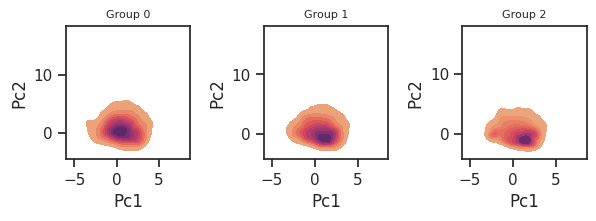

In [135]:
import math

# Define N as the total number of groups you want to plot
N = finalDf['group'].nunique()  # Number of unique groups

# Calculate the number of rows and columns needed for the grid
n_cols = 10  # You can adjust this to your preference
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each group, create a KDE plot
for i in range(0, 4):  # Loop through the number of unique groups
    ax = axs[i]
    sns.kdeplot(
        x="Pc1", y="Pc2", 
        data=finalDf.query(f"group == {i}"),
        cmap="flare", fill=True, ax=ax
    )
    ax.set_title(f'Group {i}', fontsize=8)
    # ax.set_ylim([-1, 2])
    # ax.set_xlim([-2, 4])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


In [136]:
axs

array([<Axes: title={'center': 'Group 0'}, xlabel='Pc1', ylabel='Pc2'>,
       <Axes: title={'center': 'Group 1'}, xlabel='Pc1', ylabel='Pc2'>,
       <Axes: title={'center': 'Group 2'}, xlabel='Pc1', ylabel='Pc2'>,
       <Axes: title={'center': 'Group 3'}, xlabel='Pc1', ylabel='Pc2'>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

In [137]:
mean_list = []
for i in range(0, len(data_ex['X'])):
    mean_list.append(data_ex['X'][i].mean())

In [138]:
mean_df = pd.concat([pd.DataFrame(mean_list)], axis=1)
mean_df

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util
0,3.971903,0.135258,12.418948,9388.101320,685.993189,12.430558,0.130694,66366.924470,1.436356,36.0,0.135416,45.300575
1,3.574500,0.134696,975.954407,8528.283640,681.617946,12.213486,0.103016,62951.451338,1.375784,36.0,0.134788,43.452007
2,3.277305,0.134085,753.032706,8029.734631,676.941826,12.095529,0.096114,60235.626052,1.350080,36.0,0.134448,39.237772
3,3.061507,0.134141,613.779428,7724.187682,670.141802,12.110296,0.085997,57659.183746,1.371752,36.0,0.134236,37.372316
4,2.930383,0.133288,518.820773,7506.276565,663.784375,12.157674,0.074815,56037.648547,1.376673,36.0,0.134090,37.133550
5,2.818207,0.133597,450.254050,7385.592709,659.855627,12.232928,0.068581,55310.094933,1.386175,36.0,0.133985,38.341451
6,2.687987,0.133791,398.217357,7370.801973,655.914601,12.311948,0.061205,55018.204365,1.386214,36.0,0.133904,40.082907
7,2.626056,0.134079,357.595136,7324.010233,652.235613,12.404879,0.054926,54628.018386,1.375013,36.0,0.133841,41.774205
8,2.577267,0.134711,329.803242,7419.081999,649.914162,12.500052,0.050643,54348.490846,1.377689,36.0,0.133798,43.020563
9,2.559031,0.135258,317.146925,7368.709193,647.162701,12.570305,0.048620,54056.347113,1.380383,36.0,0.133778,43.738270


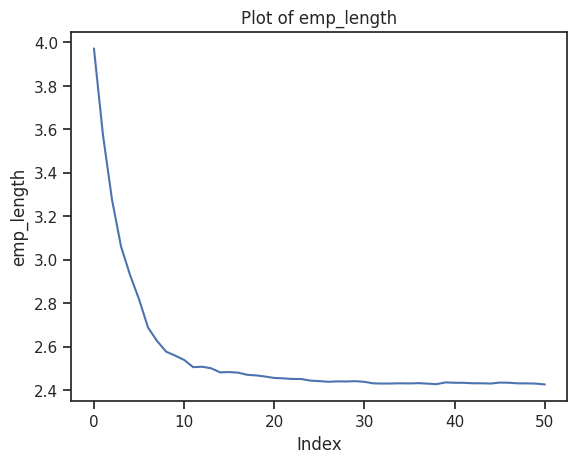

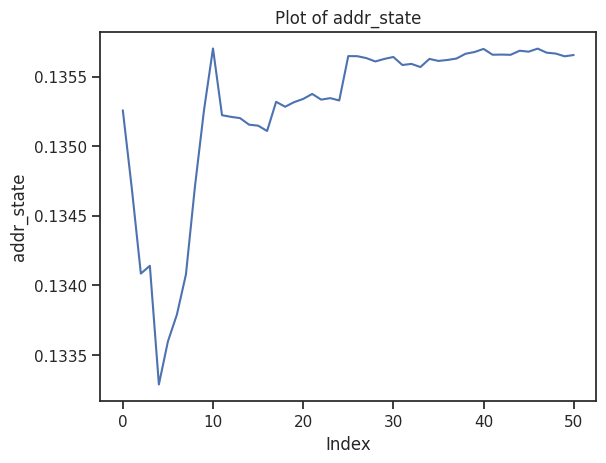

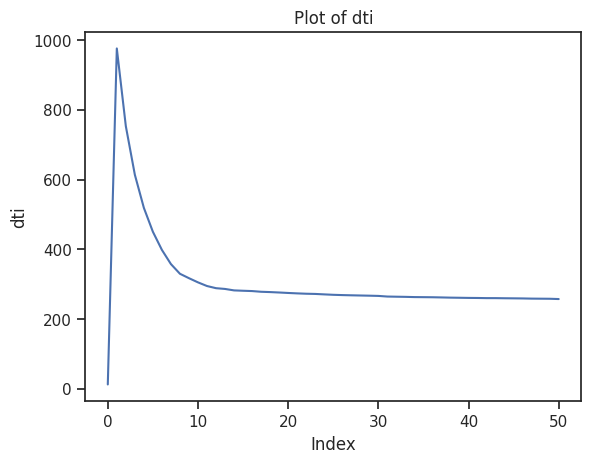

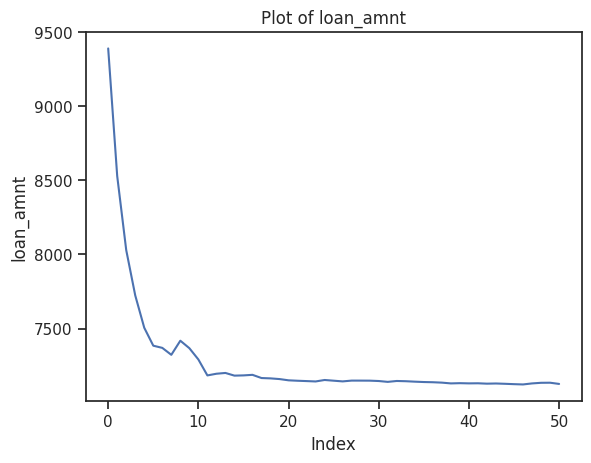

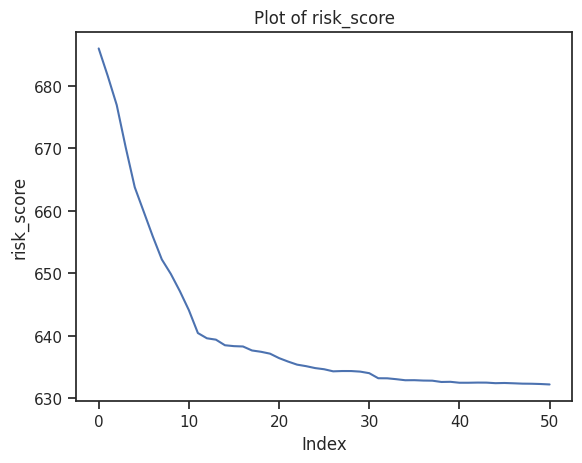

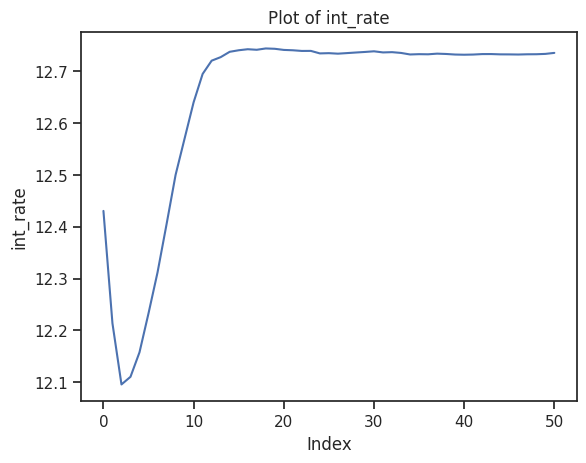

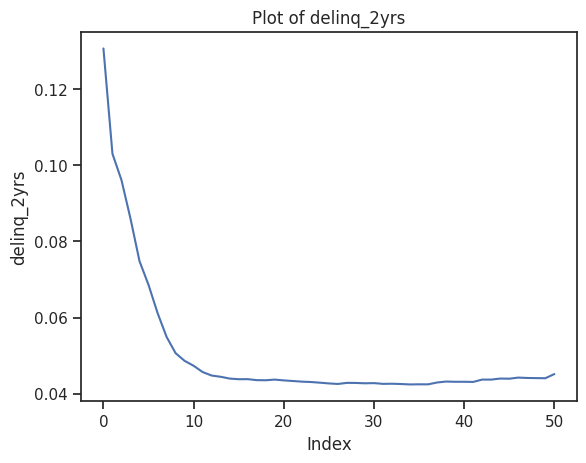

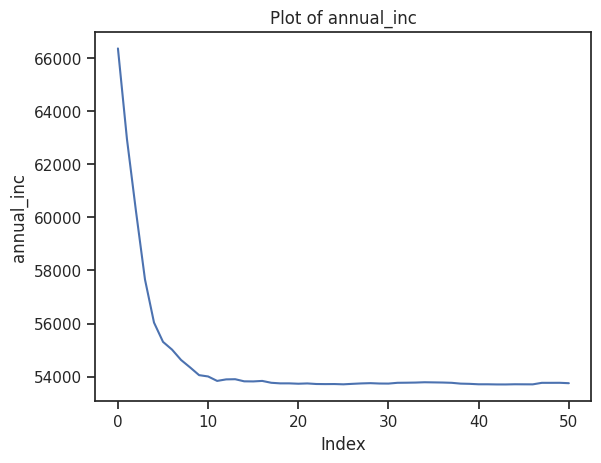

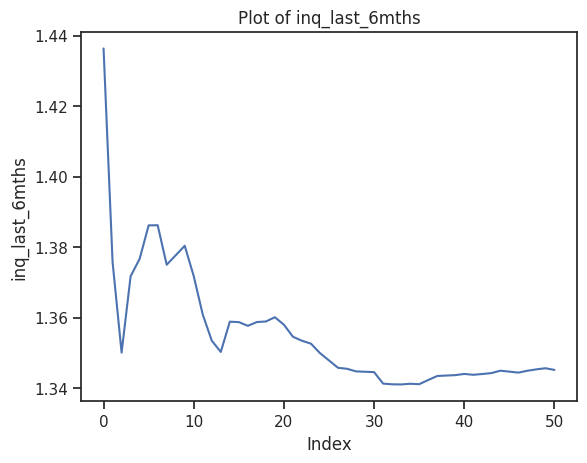

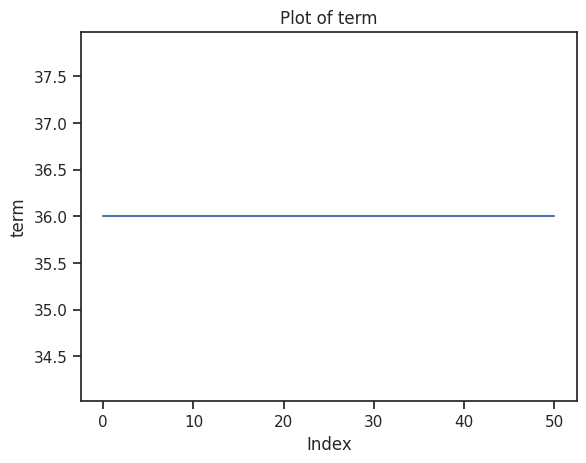

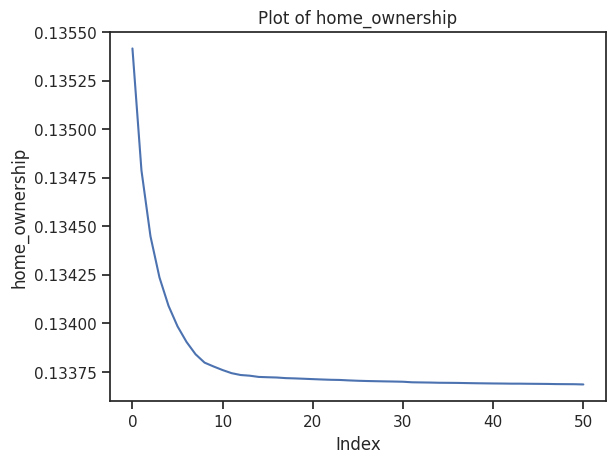

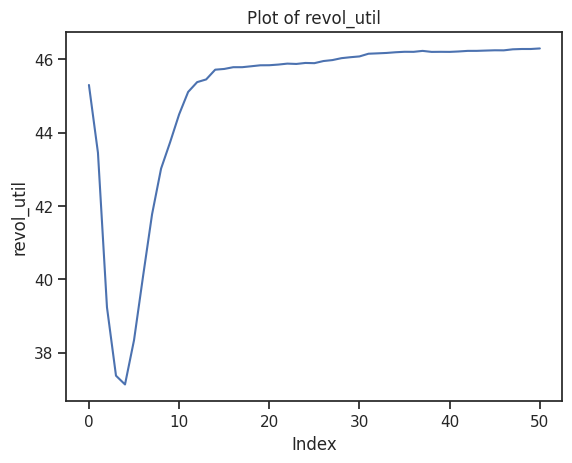

In [139]:
# Assuming 'df' is your DataFrame
for column in mean_df.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_df[column])  # Plot the column data
    plt.title(f'Plot of {column}')  # Title with the name of the column
    plt.xlabel('Index')  # X-axis label, adjust if your index has specific meaning, e.g., 'Time' or 'Date'
    plt.ylabel(column)  # Y-axis label using the column name

    # Display the plot
    plt.show()
